<a href="https://colab.research.google.com/github/david-levin11/alaska_verification/blob/main/NBM_Percentile_in_Context_EXP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NBM Percentile in Context**
A script to grab NBM percentile data, deterministic forecast and obs, and put the obs or deterministic forecast into the context of Probabilistic NBM space. This is based on code originally developed by Caleb Steele of Western Region.

-*Steve Levine - NWS MDL/Statistical Modeling Division - 2-March-2023*<br/>
-*David Levin - NWS Alaska Region ESSD - 5-July-2024*
<br/> <br/>
Updates:
> ***BUG:  StageIV QPE data no longer works due to new NWPS...need to reference IDP GIS***

> 15-Jul-2024 Fixed bug which was not displaying map for all Alaska Region

>15-Jul-2024 Included functionality to look at observations within a custom bounding box

> 5-Jul-2024 Included OCONUS functionality (AR and HFO and Puerto Rico) and also the ability to use the 24hr APRFC QC'ed gauge data as a verification source for PQPF 24hr products

> 20-Sept-2023: Included ability to work with HI/PR/AK domains (still no GU yet)

>14-Sep-2023: Updated snow plotting to work with 'unknown' name in snow total grib2 message

>10-Jul-2023: Corrected smoothling spline of percentiles so that now spline passes through relevant end points (set s = 0)

> 20-June 2023: Added deterministic 24-hour snow forecasts, which include same caveats as 24-hour QPF forecasts (random bin assignment, etc.)

> 4-Apr-2023: Added probabilistic (but not determinisitc) 24-hour snow forecasts based on NOHRSC analysis, added zero-padding for time strings where needed.  Set observed or deterministic qpf/snow to zero when value is < 0.005 inches.  Also added minor edits to plots (CWA's are now outlined in black).

> 30-Mar-2023: Fixed bug where 0.0 qpf obs were being set to NaN.  Also, assigned such obs to a random percentile bin where percentile values was also 0.0.

> 13-Mar-2023: Fixed bug with random extra obs showing up.  Also inserted exception for maximum winds, which do not exist in core/deterministic.  Fatal error will generate when attempting to work with core/deterministic max wind.

> 2-Mar-2023: Added capability for maximum wind forecast.  Note that a determinsitic/core maximum wind forecast is not available.

>>Previous development was from Caleb Steele

> 12-Aug-2022: Pretty significant update that changed much of the underlying code. Files used are now grib files (instead of the geotiffs used before), which are larger and take longer to download and decode. The gribs include more percentiles, and a cubic spline is utilized vs linear interpolation now, so the NBM distribution is much better sampled. While all 99 percentiles are avaiable, trimmed it to use 13 (1st, 5th, 10th, 20th, 30th, etc.) to save some time. If you are more patient, you can dig into the code and swap out the lists (uncomment one, uncomment the other) that will use all 99, but it will take awhile. In my limited tests, it offers little improvement in the representation of the CDF/PDF. Also wrapped everything up behind a form and added light/dark mode option. Finally, added an option to generate a csv from the dataframe that is created (helpful to make sure it has done what you expect).

> 7-Apr-2022: Added QPF, but still a lot of cleanup required. If you select Deterministic and QPF, it will really use the percentile mean. Will clean it up to use the deterministic, and add percentile mean as a separate option at some point.

> 18-Feb-2022: Added option of adding CWA boundaries, cleaned up the directories (by actually making some), and more plot tweaks so they all look as expected.

> 17-Feb-2022: fixed a hard coded reference that lead to the histogram always displaying the observation percentile distribution, even when deterministic was selected in regional plots.

> 16-Feb-2022: added "compare_to" variable which lets you switch between comparing obs and NBM determinsitic to the ProbMaxT Percentiles.

> 14-Jul-2025:  Added the ability to work with NBM 5.0 data and added MaxWind for Alaska

This first cell just imports everything we need. **NOTE: This cell will restart the notebook, which will prompt a crash popup in the lower left corner. This is safe to ignore and move on once the notebook comes back up** (you see RAM and Disk in the upper right corner).

In [14]:
#@title Initialize Notebook Part 1
!pip install -q condacolab
import condacolab
condacolab.install()
!python --version

✨🍰✨ Everything looks OK!
Python 3.11.11


The second cell should be run right after the first cell.  Note that these first two cells only need to be run once; then they will work for all other cases until you close or reset this notebook.

In [15]:
#@title Initialize Notebook Part 2
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg pygrib netCDF4
import numpy as np
from scipy.interpolate import CubicSpline as cs, UnivariateSpline as us
import pandas as pd
from urllib.request import urlretrieve, urlopen
import requests
from datetime import datetime, timedelta
import json
from netCDF4 import Dataset
import pygrib
import pyproj
from pyproj import Proj, transform
import os, re, traceback
import sys

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from matplotlib.cm import get_cmap
import seaborn as sns

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
import itertools

import zipfile

import warnings
warnings.filterwarnings("ignore")

In [28]:
#@title Select Options and Download Obs { display-mode: "form" }
#@markdown If you are using raw obs, you'll need to enter your token for the
#@markdown Synoptic API below.  Below are instructions on how to get a token:
#@markdown https://docs.google.com/document/d/1YuMUYog4J7DpFoEszMmFir4Ehqk9Q0GHG_QhSdrgV9M/edit?usp=sharing
synoptic_token = "" #@param {type:"string"}
#@markdown Which probabilistic element from the NBM?  **Note that probabilistic winds are only available for AK if you select NBM 5.0 below.**
element = "qpf" #@param ["maxt", "mint","qpf","maxwind","snow"]
valid_date = "2025-08-02" #@param {type:"date"}
#@markdown QPF valid 24 hours ending time
qpf_valid_time = 12 #@param {type:"slider", min:0, max:18, step:6}
#@markdown APRFC QC'ed gauge data instead of obs (can only check one)?

#@markdown QC gauge data is only for 24hrs valid at 12z of a calendar day.

#@markdown NOHRSC data is only available for CONUS.

#@markdown **Leaving both of these boxes unchecked is the default and results in using raw obs.**
#use_stageiv = True #@param {type:"boolean"}
# Stage IV needs to be fixed due to new NWPS page
# need to use map server at: https://mapservices.weather.noaa.gov/raster/rest/services/obs/rfc_qpe/MapServer

use_stageiv = False
use_nohrsc = False #@param {type:"boolean"}
use_QC_Gauge_Data = True #@param {type:"boolean"}
#@markdown **Which NBM version would you like to plot (the current operational version is 4.3)**
nbm_version = "5.0" #@param ["4.3", "5.0"]
#@markdown Pick NBM run time (note: add 1 hour for snow fcsts)
nbm_init_date = "2025-08-01" #@param {type:"date"}
nbm_init_hour = 0 #@param {type:"slider", min:0, max:18, step:6}
#@markdown Where do you want to focus?
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "AR", "CONUS", "CWA"]
#@markdown If CWA selected, which one? (i.e. "SLC" for Salt Lake City)
cwa_id = "AFC" #@param {type:"string"}
compare_to = "obs" #@param ["obs", "deterministic"]
#@markdown Which obs?
network_selection = "ALL" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
#@markdown If Custom or List selected for network, enter comma separated network IDs (custom) or siteids (list)  WITH NO SPACES here. For help - https://developers.synopticdata.com/about/station-providers/
network_input = ""#@param {type:"string"}
#@markdown Elevation filter?
elev_filter = False #@param {type:"boolean"}
#@markdown If elevation filter is checked which elevation to you want to filter (ft)?
elev_filter_value = 25 #@param {type:"number"}
#@markdown Would you like to filter out obs above or below this elevation?
filter_above_below = "above" #@param ["above", "below"]
#@markdown Plot CWA boundaries?
cwa_outline = False #@param {type:"boolean"}
county_outline = False #@param {type:"boolean"}
#@markdown Do you want a CSV?
export_csv = True #@param {type:"boolean"}
#@markdown Light or dark theme plots?
plot_style = "dark" #@param ["light", "dark"]
#@markdown Custom zoom area for plot (if yes then enter comma seperated lat/lon pairs for your bounding box below (Ex:  custom_southwest = 62.45,-155.55)?
custom_area = True #@param {type:"boolean"}
custom_southwest = "59.21, -154.52" #@param {type: "string"}
custom_northeast = "62.55, -145.82" #@param {type: "string"}

if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  region_list = [cwa_id]
#elif region_selection == "AR":
  #region_list=["AJK","ARH","AFC"]
else:
  region_list = [region_selection]


def cwa_list(input_region):
  region_dict ={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MTR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MFL,MOB,MAF,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA",
              "AR":"AJK,AFG,AFC"}
  if (input_region in ["WR", "CR", "SR", "ER", "AR"]):
    cwas_list = region_dict[input_region]
  else:
    cwas_list = input_region
  return cwas_list

nbm_init = datetime.strptime(nbm_init_date,'%Y-%m-%d') + timedelta(hours=int(nbm_init_hour))

if element == "maxt":
    nbm_core_valid_hour="00"
    nbm_qmd_valid_hour="06"
    valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
    valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
    obs_start_hour = "1200"
    obs_end_hour = "0600"
    ob_stat = "maximum"
    valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    nbm_core_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_core_valid_hour))
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    core_init = nbm_init + timedelta(hours = 7)
    nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init

elif element == "mint":
    nbm_core_valid_hour="12"
    nbm_qmd_valid_hour="18"
    valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
    valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d')
    obs_start_hour = "0000"
    obs_end_hour = "1800"
    ob_stat = "minimum"
    valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    nbm_core_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_core_valid_hour))
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    core_init = nbm_init + timedelta(hours = 7)
    nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init

elif element == "qpf":
    nbm_core_valid_hour = (str(qpf_valid_time)).zfill(2)
    nbm_valid_hour = (str(qpf_valid_time)).zfill(2)
    nbm_qmd_valid_hour=(str(qpf_valid_time)).zfill(2)
    valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=int(qpf_valid_time))
    valid_date_start = valid_date - timedelta(hours=24)
    valid_date_end = valid_date
    obs_start_hour = (str(qpf_valid_time)).zfill(2)+"00"
    obs_end_hour = (str(qpf_valid_time)).zfill(2)+"00"
    ob_stat = "total"
    valid_end_datetime = valid_date_end
    core_init = nbm_init
    nbm_core_valid_end_datetime = valid_date_end
    nbm_qmd_valid_end_datetime = valid_date_end
    nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init

elif element == "maxwind":
    #nbm_core_valid_hour="06"
    #nbm_valid_hour="06"
    nbm_qmd_valid_hour="06"
    obs_start_hour="0600"
    obs_end_hour="0600"
    ob_stat="maximum"
    valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
    valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
    valid_end_datetime=valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    core_init = nbm_init
    nbm_core_valid_end_datetime = valid_date_end
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    nbm_core_fhdelta = valid_end_datetime - nbm_init
    if compare_to == "deterministic":
      raise Exception("FATAL ERROR: You must compare to obs when looking at MAXWIND.  Deterministic data are not available!")
    #valid_date=date.strptime(valid_date,'') + timedelta(hours=)

elif element == "snow":# or element == "ice":
    nbm_core_valid_hour=(str(qpf_valid_time)).zfill(2)
    nbm_qmd_valid_hour=(str(qpf_valid_time)).zfill(2)
    obs_start_hour=(str(qpf_valid_time)).zfill(2)+"00"
    obs_end_hour = (str(qpf_valid_time)).zfill(2)+"00"
    valid_date = datetime.strptime(valid_date,'%Y-%m-%d') #+ timedelta(hours=int(qpf_valid_time))
    valid_date_start = valid_date - timedelta(hours=24)
    valid_date_end = valid_date
    valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    ob_stat = "total"
    core_init = nbm_init + timedelta(hours = 1)
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    nbm_core_valid_end_datetime = nbm_qmd_valid_end_datetime
    nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init
    #if compare_to == "deterministic":
    #  raise Exception("FATAL ERROR: You must compare to obs when looking at snow/ice.  Determinsitic data are not avialable yet.")

current_datetime = datetime.now()

nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
if element == "snow" or element == "qpf":
  nbm_core_forecasthour_start = nbm_core_forecasthour - 24
else:
  nbm_core_forecasthour_start = nbm_core_forecasthour - 12
nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
if element == "qpf" or element == "maxwind" or element == "maxgust" or element == "snow" or element == "ice24":
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 24
else:
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18

# checking to make sure our qpf data selection is valid
if element == 'qpf' and use_QC_Gauge_Data:
  today = datetime.utcnow()
  print(today)
  qpeday = ((today-valid_date_end)+timedelta(days=1)).days
  print('QPE day is day '+str(qpeday))
  if qpeday > 29:
    print("Valid date is outside the range of RFC QPE files...switching to raw obs")
    use_QC_Gauge_Data = False
  if qpf_valid_time != 12:
    print("You have selected a QPF valid time of "+ str(qpf_valid_time))
    print("This is invalid as QC gauge data is only valid at 12z...switching to raw obs!")
    use_QC_Gauge_Data = False




statistics_api = "https://api.synopticlabs.org/v2/stations/legacystats?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"

# Setup a diting a form selection into a sometctionary for translahing we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":"", "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]

if element == "qpf":
  cmap = get_cmap('PiYG')
  cmap.set_under(color='red')
  cmap.set_over(color='yellow')
elif element == "snow":
  cmap = get_cmap('cool_r')
  cmap.set_under(color='black')
  cmap.set_over(color='yellow')
else:
  #cmap = 'Spectral'
  cmap = get_cmap('bwr')
  cmap.set_under(color='yellow')
  cmap.set_over(color='black')
if use_stageiv and element=="qpf":
  points_str = f'Stage IV @ {network_selection}'
else:
  points_str = network_selection

if plot_style=="light":
  background_color = '#f7f7f7'
  text_color = '#121212'
  map_land_color = '#FAFAF8'
  map_water_color = '#D4DBDD'
  map_border_color = 'grey'
elif plot_style=="dark":
  background_color = '#272727'
  text_color = 'white'
  map_land_color = '#414143'
  map_water_color = '#272727'
  #map_border_color = '#3B3B3D'
  map_border_color = 'white'


########################################################################################################################
# Reusable functions section                                                                                           #
########################################################################################################################

def project3(lon, lat, prj):
  lon = float(lon)
  lat = float(lat)

  outproj = prj
  inproj = Proj(init='epsg:4326')
  nbm_coords = transform(inproj, outproj, lon, lat)
  coordX = nbm_coords[0]
  coordY = nbm_coords[1]
  #print(f'Lat: {lat}, Y: {coordY} | Lon: {lon}, X: {coordX}')
  return(coordX, coordY)


def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)


def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)

  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])

  return hrap_idx

def nohrsc_ll2ij(lon,lat,gridlons,gridlats):
  #for a lat/lon grid
  lon = float(lon)
  lat = float(lat)
  lonidx=(np.abs(lon-gridlons)).argmin()
  latidx=(np.abs(lat-gridlats)).argmin()
  return(latidx,lonidx)

def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+valid_date_end.strftime('%Y')+"/"+valid_date_end.strftime('%m')+"/"+valid_date_end.strftime('%d')+"/nws_precip_1day_"+valid_date_end.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()
  print(siv_url)
  print(data)
  print(f'Valid date end is: {valid_date_end}')
  nc = Dataset('data', memory=data)
  #with Dataset(siv_file, 'r') as nc:
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y

def get_nohrsc():
  nohrsc_url = "https://www.nohrsc.noaa.gov/snowfall_v2/data/"+valid_date_end.strftime('%Y%m')+"/sfav2_CONUS_24h_"+valid_date_end.strftime('%Y%m%d%H')+".nc"
  data = urlopen(nohrsc_url).read()

  nc = Dataset('data',memory=data)
  snow=np.asarray(nc.variables['Data']) #make lon by lat array (original lat by lon)
  snowlat = np.asarray(nc.variables['lat'])
  snowlon = np.asarray(nc.variables['lon'])
  return snow,snowlon,snowlat

def get_qc_data():
    today = datetime.utcnow()
    print(today)
    qpeday = (today-valid_date_end)+timedelta(days=1)
    print(qpeday.days)
    try:
      qcurl = f'https://www.weather.gov/source/aprfc/verification/QPEday{qpeday.days}.csv'
      csv_name = f'{qpeday.days}.csv'
      print(f'QC url is: {qcurl}')
      response = requests.get(qcurl)
      with open(csv_name, 'wb') as f:
          f.write(response.content)
      with open(csv_name, 'r') as fl:
          header = fl.readline().strip()
          fl_date_raw = header.split(' - ')[1]
          fl_date = datetime.strptime(fl_date_raw, '%Y%m%d %Hz')
          print(fl_date)
      if fl_date == valid_date_end:
          qcdata = pd.read_csv(csv_name, skiprows=2, names=['stid', 'obs_qpf'])
      else:
          qcurl = f'https://www.weather.gov/source/aprfc/verification/QPEday{int(qpeday.days-1)}.csv'
          csv_name = f'{int(qpeday.days-1)}.csv'
          print(f'Valid url is: {qcurl}')
          response = requests.get(qcurl)
          with open(csv_name, 'wb') as f:
              f.write(response.content)
          qcdata = pd.read_csv(csv_name, skiprows=2, names=['stid', 'obs_qpf'])
    except Exception as e:
      print("Error retreiving RFC data...exiting the script")
      print(e)
      qcdata = pd.DataFrame()
    return qcdata

def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit

def mps_to_kts(mps):
  kts = mps * 1.94384
  return kts

def mm_to_in(millimeters):
  inches = millimeters * 0.0393701
  return inches

def meters_to_in(meters):
  inches = meters*39.3701
  return inches

def find_roots(x,y):
  s = np.abs(np.diff(np.sign(y))).astype(bool)
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)


def download_subset(remote_url, remote_file, local_filename):
  print("   > Downloading a subset of NBM gribs")
  local_file = "nbm/"+local_filename
  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
    elif element == "maxwind":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 == 0):
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start/24))}-{str(int(nbm_qmd_forecasthour/24))} hour max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
    elif element == "snow":
      search_string = f':ASNOW:surface:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour acc'
  #print("Search string = ",search_string)
  idx = remote_url+".idx"
  #print("IDX file = " + idx)
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  expr
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
    # n is the line number (starting from 1) so that when we call for
    # `lines[n]` it will give us the next line. (Clear as mud??)
    # Use the compiled regular expression to search the line
    #print(">> Searching throgh this line: " + line)
    if expr.search(line):
      # aka, if the line contains the string we are looking for...
      # Get the beginning byte in the line we found
      parts = line.split(':')
      rangestart = int(parts[1])
      # Get the beginning byte in the next line...
      if n+1 < len(lines):
        # ...if there is a next line
        parts = lines[n].split(':')
        rangeend = int(parts[1])
      else:
        # ...if there isn't a next line, then go to the end of the file.
        rangeend = ''

        # Store the byte-range string in our dictionary,
        # and keep the line information too so we can refer back to it.
      byte_ranges[f'{rangestart}-{rangeend}'] = line
      #print(line)
    #else:
      #print(">>>  Could not find search string!")
  #print(">>  Number of items in byteRange:" + str(len(byte_ranges)))
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

    if i == 0:
      # If we are working on the first item, overwrite the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
      #print(">>  Adding curl command: " + curl)
    else:
      # If we are working on not the first item, append the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
      #print("Adding curl command: " + curl)
    #print('>>  Parsing line: ' + line)
    try:
      num, byte, date, var, level, forecast, _ = line.split(':')
    except:
      pass
      #print(">>>  Can't get num/byte/etc from this line, so skipping...")

    #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
    #print(f'  Downloading GRIB line: variable={var}, level={level}, forecast={forecast}')
    #print("Running the curl command...")
    os.system(curl)

  if os.path.exists(local_file):
    print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
    return local_file
  else:
    print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))


########################################################################################################################
# This section for downloading and processing obs                                                                      #
########################################################################################################################
print('Getting obs...')
if custom_area:
  lonmin = float(custom_southwest.split(',')[1])
  latmin = float(custom_southwest.split(',')[0])
  lonmax = float(custom_northeast.split(',')[1])
  latmax = float(custom_northeast.split(',')[0])
obs ={}
for region in region_list:
  if (valid_end_datetime <= current_datetime):
    print("   > Grabbing obs for: ", region)
    #print("List of CWAs: ", cwa_list(region) )
    json_name = "obs/Obs_"+element+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+region+".json"
    if os.path.exists("obs"):
      pass
    else:
      os.mkdir("obs")

    #if element != "qpf":
    if element == "mint" or element == "maxt":
      api_token = "&token="+synoptic_token
      if custom_area:
        station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
      else:
        station_query = "&cwa="+cwa_list(region)
      vars_query = "&vars=air_temp"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      api_extras = "&units=temp%7Cf&within=1440&status=active"
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
    elif element == "maxwind":
      api_token = "&token="+synoptic_token
      if custom_area:
        station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
      else:
        station_query = "&cwa="+cwa_list(region)
      vars_query = "&vars=wind_speed"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      #api_extras =
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query
    elif element == "qpf":
      if use_stageiv and not use_QC_Gauge_Data:
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        stageIV, s4xs, s4ys = get_stageiv()
        s4xs, s4ys = np.meshgrid(s4xs, s4ys)
      elif use_QC_Gauge_Data and not use_stageiv:
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        print(f'Obs URL is: {obs_url}')
        qc_df = get_qc_data()
        #print(f'QC data is: {qc_df}')
        is_empty = qc_df.empty
        if is_empty:
          sys.exit()
      elif use_QC_Gauge_Data and use_stageiv:
        print('You cannot use both StageIV AND QC Gauge data silly! Reverting to obs only...')
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
      else:
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        print(network_string)
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    elif element == "snow":
      if use_nohrsc:
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        snow,snowlon,snowlat = get_nohrsc()
        snowlons,snowlats = np.meshgrid(snowlon,snowlat)
      else:
        api_token = "&token="+synoptic_token
        if custom_area:
          station_query = f"&bbox={lonmin},{latmin},{lonmax},{latmax}"
        else:
          station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    print("Obs url: " + obs_url)
    if os.path.exists(json_name):
      print ("Deleting old JSON file")
      os.remove(json_name)
      urlretrieve(obs_url, json_name)
    else:
      urlretrieve(obs_url, json_name)

    if os.path.exists(json_name):
        with open(json_name) as json_file:
            obs_json = json.load(json_file)
            print ("Loaded Obs JSON file line 343: " + json_name)
            obs_lats = []
            obs_lons = []
            obs_value = []
            obs_elev = []
            obs_stid = []
            obs_name = []
            for stn in obs_json["STATION"]:
                # print(stn.encode('utf-8'))
                if stn["STID"] is None:
                  stid = "N0N3"
                else:
                  stid = stn["STID"]
                #print(f'Processing {region} station {stid}')
                name = stn["NAME"]
                if stn["ELEVATION"] and stn["ELEVATION"] is not None:
                  elev = stn["ELEVATION"]
                else:
                  elev = -999
                lat = stn["LATITUDE"]
                lon = stn["LONGITUDE"]
                if float(lon) > -50:
                  continue #bug fix to deal with errant synoptic labs obs in the file
                if element == "mint" or element=="maxt":
                  if 'air_temp_set_1' in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                    if ob_stat in stn['STATISTICS']['air_temp_set_1']: # and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                      stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(float(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(float(stat))
                elif element == "maxwind":
                  if 'wind_speed_set_1' in stn['STATISTICS'] and stn['STATISTICS']['wind_speed_set_1']:
                    if ob_stat in stn['STATISTICS']['wind_speed_set_1']: # and float(stn["LATITUDE"]) != 0.:
                      stat = stn['STATISTICS']['wind_speed_set_1'][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(float(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(mps_to_kts(float(stat)))
                elif (element == "qpf"):
                  if (stn["STATUS"] == "ACTIVE"): # and float(stn["LATITUDE"]) < 50.924 and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                    obs_stid.append(str(stid))
                    obs_name.append(str(name))
                    obs_elev.append(float(elev))
                    obs_lats.append(float(lat))
                    obs_lons.append(float(lon))
                    if use_stageiv and not use_QC_Gauge_Data:
                      coords = project_hrap(lon, lat, s4xs, s4ys)
                      siv_value = float(stageIV[coords])
                      if (siv_value >= 0.01):
                        obs_value.append(siv_value)
                      else:
                        obs_value.append(0.0)
                    elif use_QC_Gauge_Data and not use_stageiv:
                      if stn['STID'] in qc_df['stid'].values.tolist():
                        pcp_amt = qc_df.loc[qc_df['stid'] == stn['STID'], 'obs_qpf'].iloc[0]
                        obs_value.append(float(pcp_amt))
                      else:
                        obs_value.append(np.nan)
                    elif use_QC_Gauge_Data and use_stageiv:
                      if "precipitation" in stn["OBSERVATIONS"]:
                        if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                           ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                           if ptotal >= 0.005:
                              obs_value.append(ptotal)
                           else:
                              obs_value.append(0.0)
                        else:
                            obs_value.append(np.nan)
                      else:
                          obs_value.append(np.nan)
                    else:
                      if "precipitation" in stn["OBSERVATIONS"]:
                        if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                          ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                          if ptotal >= 0.005:
                            obs_value.append(ptotal)
                          else:
                            obs_value.append(0.0)
                        else:
                          obs_value.append(np.nan)
                      else:
                        obs_value.append(np.nan)
                elif (element == "snow"):
                  if stn["STATUS"] == "ACTIVE": # and float(stn["LATITUDE"]) < 50.924)and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                    obs_stid.append(str(stid))
                    obs_name.append(str(name))
                    obs_elev.append(float(elev))
                    obs_lats.append(float(lat))
                    obs_lons.append(float(lon))
                    if use_nohrsc:
                      coords = nohrsc_ll2ij(lon,lat,snowlon,snowlat)
                      nohrsc_value = meters_to_in(float(snow[coords]))
                      if nohrsc_value >= 0.005:
                        obs_value.append(nohrsc_value)
                      elif nohrsc_value < 0.0:
                        obs_value.append(np.nan)
                      else:
                        obs_value.append(0.0)
                    else:
                      raise Exception("Still not able to process individual snow obs!")
            csv_name = "obs_"+element+"_"+region+".csv"
            obs[region] = pd.DataFrame()
            obs[region]["stid"] = obs_stid
            obs[region]["name"] = obs_name
            obs[region]["elevation"] = obs_elev
            obs[region]["lat"] = obs_lats
            obs[region]["lon"] = obs_lons
            obs[region]["ob_"+element] = obs_value
            obs[region].dropna(inplace=True)
            if elev_filter and filter_above_below == "above":
              obs[region] = obs[region][obs[region]["elevation"] <= elev_filter_value]
            if elev_filter and filter_above_below == "below":
              obs[region] = obs[region][obs[region]["elevation"] >= elev_filter_value]
            obs[region].to_csv(csv_name)
  else:
    print(f'    > Valid Time in the future. Grabbing obs points only for: {region}')
    json_name = "obs/ObsPoints_"+region+"_wcoss.json"
    if os.path.exists(json_name):
      pass
    else:
      if os.path.exists("obs"):
        pass
      else:
        os.mkdir("obs")
      obs_url = "https://api.synopticdata.com/v2/stations/metadata?&token="+synoptic_token+"&cwa="+cwa_list(region)+"&fields=status,latitude,longitude,name,elevation"+network_string
      urlretrieve(obs_url, json_name)
    if os.path.exists(json_name):
      with open(json_name) as json_file:
          obs_json = json.load(json_file)
          print("Loaded Obs JSON file line 427!")
          obs_lats = []
          obs_lons = []
          obs_elev = []
          obs_stid = []
          obs_name = []
          for stn in obs_json["STATION"]:
            # print(stn.encode('utf-8'))
            if stn["STID"] is None:
              stid = "N0N3"
            else:
              stid = stn["STID"]
            #print(f'Processing {region} station {stid}')
            name = stn["NAME"]
            if stn["ELEVATION"] and stn["ELEVATION"] is not None:
              elev = stn["ELEVATION"]
            else:
              elev = -999
            lat = stn["LATITUDE"]
            lon = stn["LONGITUDE"]
            if stn["STATUS"] == "ACTIVE": # and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(float(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
          obs[region] = pd.DataFrame()
          obs[region]["stid"] = obs_stid
          obs[region]["name"] = obs_name
          obs[region]["elevation"] = obs_elev
          obs[region]["lat"] = obs_lats
          obs[region]["lon"] = obs_lons
          obs[region]["ob_"+element] = -999
          obs[region].dropna(inplace=True)
          #obs[region].to_csv(csv_name)


2025-08-04 17:29:57.484698
QPE day is day 3
Getting obs...
   > Grabbing obs for:  AFC
Obs URL is: https://api.synopticdata.com/v2/stations/metadata?&token=c6c8a66a96094960aabf1fed7d07ccf0&bbox=-154.52,59.21,-145.82,62.55&fields=status,latitude,longitude,name,elevation
2025-08-04 17:29:57.499281
3
QC url is: https://www.weather.gov/source/aprfc/verification/QPEday3.csv
2025-08-02 12:00:00
Obs url: https://api.synopticdata.com/v2/stations/metadata?&token=c6c8a66a96094960aabf1fed7d07ccf0&bbox=-154.52,59.21,-145.82,62.55&fields=status,latitude,longitude,name,elevation
Deleting old JSON file
Loaded Obs JSON file line 343: obs/Obs_qpf_202508011200_202508021200_AFC.json


In [29]:
#@title Download Gribs and Interpolate
########################################################################################################################
# This section downloads and processes the NBM.                                                                        #
########################################################################################################################
if "AR" in region_list or "AJK" in region_list or "ARH" in region_list or "AFC" in region_list or "AFG" in region_list:
  rg="ak"
elif "HFO" in region_list:
  rg="hi"
elif "SJU" in region_list:
  rg="pr"
else:
  rg="co"
print(f'Region list is: {region_list}')
print(f'Region is: {rg}')
print('Getting and processing NBM...')
nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
if nbm_version == "4.3":
  nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
              +"/"+nbm_init.strftime('%H')+"/"
  nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
              +"/"+core_init.strftime('%H')+"/"
else:
  nbm_url_base = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
              +"/"+nbm_init.strftime('%H')+"/"
  nbm_url_base_core = "https://noaa-nbm-para-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
              +"/"+core_init.strftime('%H')+"/"
temp_vars = ["maxt","mint"]
if (element == "qpf"):
  detr_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{rg}.grib2'
  if nbm_version == "4.3":
    detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset.grib2'
  else:
    detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset_exp.grib2'
  detr_url = nbm_url_base+"qmd/"+detr_file

elif any(te in element for te in temp_vars):
  detr_file = f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.{rg}.grib2"
  if nbm_version == "4.3":
    detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.{rg}.{element}_subset.grib2"
  else:
    detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.{rg}.{element}_subset_exp.grib2"
  detr_url = nbm_url_base_core+"core/"+detr_file

elif element == "maxwind" or element == "maxgust":
  print("MAXWIND: No Core data available!")
  #core_init = nbm_init
  #nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

elif element == "snow":
  #for snow, even for prob/perecntiles, we are dealing with a core file
  detr_file=f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.{rg}.grib2"
  if nbm_version == "4.3":
    detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.{rg}.{element}_subset.grib2"
  else:
    detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.{rg}.{element}_subset_exp.grib2"
  detr_url = nbm_url_base_core+"core/"+detr_file
  #raise Exception ("Not ready to deal with snow deterministic yet!")
  #print("SNOW: No Core data avaialable!")

if element != "maxwind" and element != "maxgust": # and element != "snow":
  if os.path.exists("nbm/"+detr_file_subset):
    print("   > NBM deterministic already exists")
  else:
    print("   > Getting NBM deterministic")
    if os.path.exists("nbm"):
      pass
    else:
      os.mkdir("nbm")
    #urlretrieve(detr_url, "nbm/"+detr_file)
    download_subset(detr_url, detr_file, detr_file_subset)
  #print(detr_url)
  nbmd = pygrib.open("nbm/"+detr_file_subset)
  if element == "maxt":
    deterministic = nbmd.select(name="Maximum temperature",lengthOfTimeRange=12, stepTypeInternal="max")[0]
    deterministic_array = K_to_F(deterministic.values)
  elif element == "mint":
    deterministic = nbmd.select(name="Minimum temperature",lengthOfTimeRange=12, stepTypeInternal="min")[0]
    deterministic_array = K_to_F(deterministic.values)
  elif element == "qpf":
    deterministic = nbmd.select(name="Total Precipitation",lengthOfTimeRange=24)[-1]
    deterministic_array = mm_to_in(deterministic.values)
  if element == "snow":
    deterministic = nbmd.select(name="unknown",lengthOfTimeRange=24)[7] #look at 8th record
    deterministic_array = mm_to_in(deterministic.values)
  nbmlats, nbmlons = deterministic.latlons()
  nbmd.close()

  for region in region_list:
    print("     >> Extracting NBM deterministic")
    point_lats = obs[region]["lat"].values
    point_lons = obs[region]["lon"].values
    detr_values = []
    nbm_fidx = []
    for i in range(0, len(point_lats)):
      coords = ll_to_index(nbmlons, nbmlats, point_lons[i], point_lats[i])
      detr_value = deterministic_array[coords]
      nbm_fidx.append(coords)
      if (element == "qpf") and detr_value < 0.005: #set very light values to zero
        detr_value = 0.0
      detr_values.append(detr_value)
    obs[region]["NBM_fidx"] = nbm_fidx
    obs[region]["NBM_D"] = detr_values
else:
  #set up forecast dataframe for wind/gust, but make determinstic values nan
  print("MAXWIND: Putting station locations into dataframe")
  #fcst[cwa]=pd.DataFrame()
  point_lats = obs[region]["lat"].values
  point_lons = obs[region]["lon"].values
  nbm_fidx = []
  nbmlats=None
  nbmlons=None
  stations = obs[region]["stid"]
  detr_values=np.empty(np.shape(stations))
  detr_values.fill(np.nan)
  obs[region]["NBM_D"] = detr_values

if nbm_version == "4.3":
  if element == "snow":
    perc_list = [5,10,25,50,75,90,95]
  else:
    perc_list = [1,5,10,20,30,40,50,60,70,80,90,95,99]
else:
  if element == "snow":
    perc_list = [5,10,25,50,75,90,95]
  else:
    perc_list = [0,5,10,20,30,40,50,60,70,80,90,95,100]
#perc_list = range(1,100,1)
perc_dict = {"maxt":"maxt18p", "mint":"mint18p", "qpf":"qpf24p", "snow":"snow24p"}
if element == "snow":
  perc_file=f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.{rg}.grib2"
  perc_url=nbm_url_base_core+"core/"+perc_file
else:
  perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{rg}.grib2'
  perc_url = nbm_url_base+"qmd/"+perc_file
if nbm_version == "4.3":
  perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset.grib2'
else:
  perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset_exp.grib2'
print("perc_url=",perc_url)
print("perc_file=",perc_file)
if os.path.exists("nbm"):
  pass
else:
  os.mkdir("nbm")
if os.path.exists("nbm/"+perc_file_subset):
  print("   > NBM probabilistic already exists")
else:
  #urlretrieve(perc_url, "nbm/"+perc_file)
  print("   > Getting NBM probabilistic")
  download_subset(perc_url, perc_file, perc_file_subset)


def select_from_prob_msgs(prob_msgs, **criteria):
    matches = []
    for g in prob_msgs:
        try:
            if all(getattr(g, k) == v for k, v in criteria.items()):
                matches.append(g)
        except Exception:
            continue
    return matches
#nbmperc = pygrib.open("nbm/"+perc_file_subset)
all_msgs = pygrib.open("nbm/" + perc_file_subset)
# Filter messages that have a percentileValue key
prob_msgs = [g for g in all_msgs if "percentileValue" in g.keys()]

print(f"Filtered {len(prob_msgs)} probabilistic messages out of {all_msgs.messages} total")

#for i, g in enumerate(nbmperc):
#    print(f"\nMessage #{i + 1}")
#    print("Name:", g.name)
#    print("Available keys:")
#    for key in g.keys():
#        print(f"  {key}")
print('   > Extracting NBM Probabilistic')
for perc in perc_list:
  print(f'     >> Extracting NBM P{int(perc):01}')
  perc_name = "NBM_P"+str(perc)
  if element == "maxt":
    try:
      percdata = K_to_F(select_from_prob_msgs(prob_msgs, name="Time-maximum 2 metre temperature", stepTypeInternal="max", percentileValue=perc)[0].values)
    except IndexError:
      percdata = K_to_F(select_from_prob_msgs(prob_msgs, name="2 metre temperature", stepTypeInternal="max", percentileValue=perc)[0].values)
  elif element == "mint":
    try:
      percdata = K_to_F(select_from_prob_msgs(prob_msgs, name="Time-minimum 2 metre temperature", stepTypeInternal="min", percentileValue=perc)[0].values)
    except IndexError:
      percdata = K_to_F(select_from_prob_msgs(prob_msgs, name="2 metre temperature", stepTypeInternal="min", percentileValue=perc)[0].values)
  elif element == "qpf":
    percdata = mm_to_in(select_from_prob_msgs(prob_msgs, name="Total Precipitation",lengthOfTimeRange=24, percentileValue=perc)[0].values)
  elif element == "maxwind":
    try:
      percinv = select_from_prob_msgs(prob_msgs,name="10 metre wind speed",lengthOfTimeRange=24,stepTypeInternal="max",percentileValue=perc)[0]
    except IndexError:
      percinv = select_from_prob_msgs(prob_msgs,name="Time-maximum 10 metre wind speed",lengthOfTimeRange=24,percentileValue=perc)[0]
    percdata = mps_to_kts(percinv.values)
  elif element == "snow":
    percinv = select_from_prob_msgs(prob_msgs, name="unknown",lengthOfTimeRange=24,percentileValue=perc)[0]
    percdata=meters_to_in(percinv.values)
  if nbmlats is None:
    nbmlats,nbmlons=percinv.latlons()
    for i in range(0,len(point_lats)):
      coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
      nbm_fidx.append(coords)
    obs[region]["NBM_fidx"] = nbm_fidx
  for region in region_list:
    nbm_coords = obs[region]["NBM_fidx"].values
    perc_values = []
    for i in range(0, len(nbm_coords)):
      perc_value = percdata[nbm_coords[i]]
      perc_values.append(perc_value)
    obs[region][perc_name] = perc_values
all_msgs.close()


########################################################################################################################
# This section creates a distribution curve at each site, and interpolates ob and deterministic to percentile space    #
########################################################################################################################
print('Creating point distribution curves and interpolating...')
if nbm_version == "4.3":
  start_loc = "NBM_P1"
  end_loc = "NBM_P99"
else:
  start_loc = "NBM_P0"
  end_loc = "NBM_P100"
for region in region_list:
  if element == "snow":
    perc_start = obs[region].columns.get_loc("NBM_P5")
    perc_end = obs[region].columns.get_loc("NBM_P95")
    all_percs = obs[region].iloc[:, perc_start:perc_end+1].values
  else:
    perc_start = obs[region].columns.get_loc(start_loc)
    perc_end = obs[region].columns.get_loc(end_loc)
    all_percs = obs[region].iloc[:, perc_start:perc_end+1].values
  var_string = "ob_"+element
  all_obs = obs[region][[var_string]].values
  all_nbmd = obs[region][['NBM_D']].values
  obs_percs = []
  nbmd_percs = []
  for i in range(0,len(all_obs)):
    udf = us(perc_list, all_percs[i,:], bbox=[0,100], ext=0, s=0)
    if np.isnan(all_obs[i]):
      ob_perc = np.nan
    elif all_obs[i] == 0.0 and (element == "qpf" or element == "snow"):
        zo=len(perc_list)-np.count_nonzero(all_percs[i,:])
        if zo == 0:
          ob_perc = -10
        elif zo == 1:
          ob_perc = 10
        else:
          ob_perc = np.random.randint(low=1,high=perc_list[zo-1])
    elif all_obs[i] < udf(0):
      ob_perc = -10
    elif all_obs[i] > udf(100):
      ob_perc = 110
    else:
      ob_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_obs[i])
      ob_perc = ob_perc[0].round(1)

    if np.isnan(all_nbmd[i]):
      nbm_perc = np.nan
    elif all_nbmd[i] == 0.0 and (element == "qpf" or element == "snow"):
      zn=len(perc_list)-np.count_nonzero(all_percs[i,:])
      if zn == 0:
        nbm_perc = -10
      elif zn == 1:
        nbm_perc = 10
      else:
        #print(f'zn is: {zn} and zo -1 is : {zo-1}')
        #print(f'percent list is: {perc_list}')
        nbm_perc = np.random.randint(low=1,high=perc_list[zn-1])
        #print(f' NBM percentile is: {nbm_perc}')
    elif all_nbmd[i] < udf(0):
      nbm_perc = -10
    elif all_nbmd[i] > udf(100):
      nbm_perc = 110
    else:
      nbm_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_nbmd[i])
      nbm_perc = nbm_perc[0].round(1)

    if np.isnan(ob_perc):
      obs_percs.append(ob_perc)
    else:
      obs_percs.append(int(ob_perc))
    if np.isnan(nbm_perc):
      nbmd_percs.append(nbm_perc)
    else:
      nbmd_percs.append(int(nbm_perc))
  obs[region]["ob_perc"] = obs_percs
  obs[region]["NBMd_perc"] = nbmd_percs
  if export_csv:
    csv_name = "obs_and_percs_"+element+"_"+nbm_init.strftime('%Y%m%d')+"_"+valid_end_datetime.strftime('%Y%m%d')+"_"+region+".csv"
    obs[region].to_csv(csv_name)
    print(f'   > Created and saved {csv_name}')

Region list is: ['AFC']
Region is: ak
Getting and processing NBM...
   > Getting NBM deterministic
   > Downloading a subset of NBM gribs
      ✅ Success! Searched for [:APCP:surface:12-36 hour acc fcst:] and got [32] GRIB fields and saved as nbm/blend.t00z.qmd.20250801_0020250801_00f036.ak.qpf_subset_exp.grib2
     >> Extracting NBM deterministic
perc_url= https://noaa-nbm-para-pds.s3.amazonaws.com/blend.20250801/00/qmd/blend.t00z.qmd.f036.ak.grib2
perc_file= blend.t00z.qmd.f036.ak.grib2
   > NBM probabilistic already exists
Filtered 21 probabilistic messages out of 32 total
   > Extracting NBM Probabilistic
     >> Extracting NBM P0
     >> Extracting NBM P5
     >> Extracting NBM P10
     >> Extracting NBM P20
     >> Extracting NBM P30
     >> Extracting NBM P40
     >> Extracting NBM P50
     >> Extracting NBM P60
     >> Extracting NBM P70
     >> Extracting NBM P80
     >> Extracting NBM P90
     >> Extracting NBM P95
     >> Extracting NBM P100
Creating point distribution curve

Making plot (almost done!)...
   > Done! Saved plot as map_5.0_AFC_Obs_qpf_20250801_20250802.png


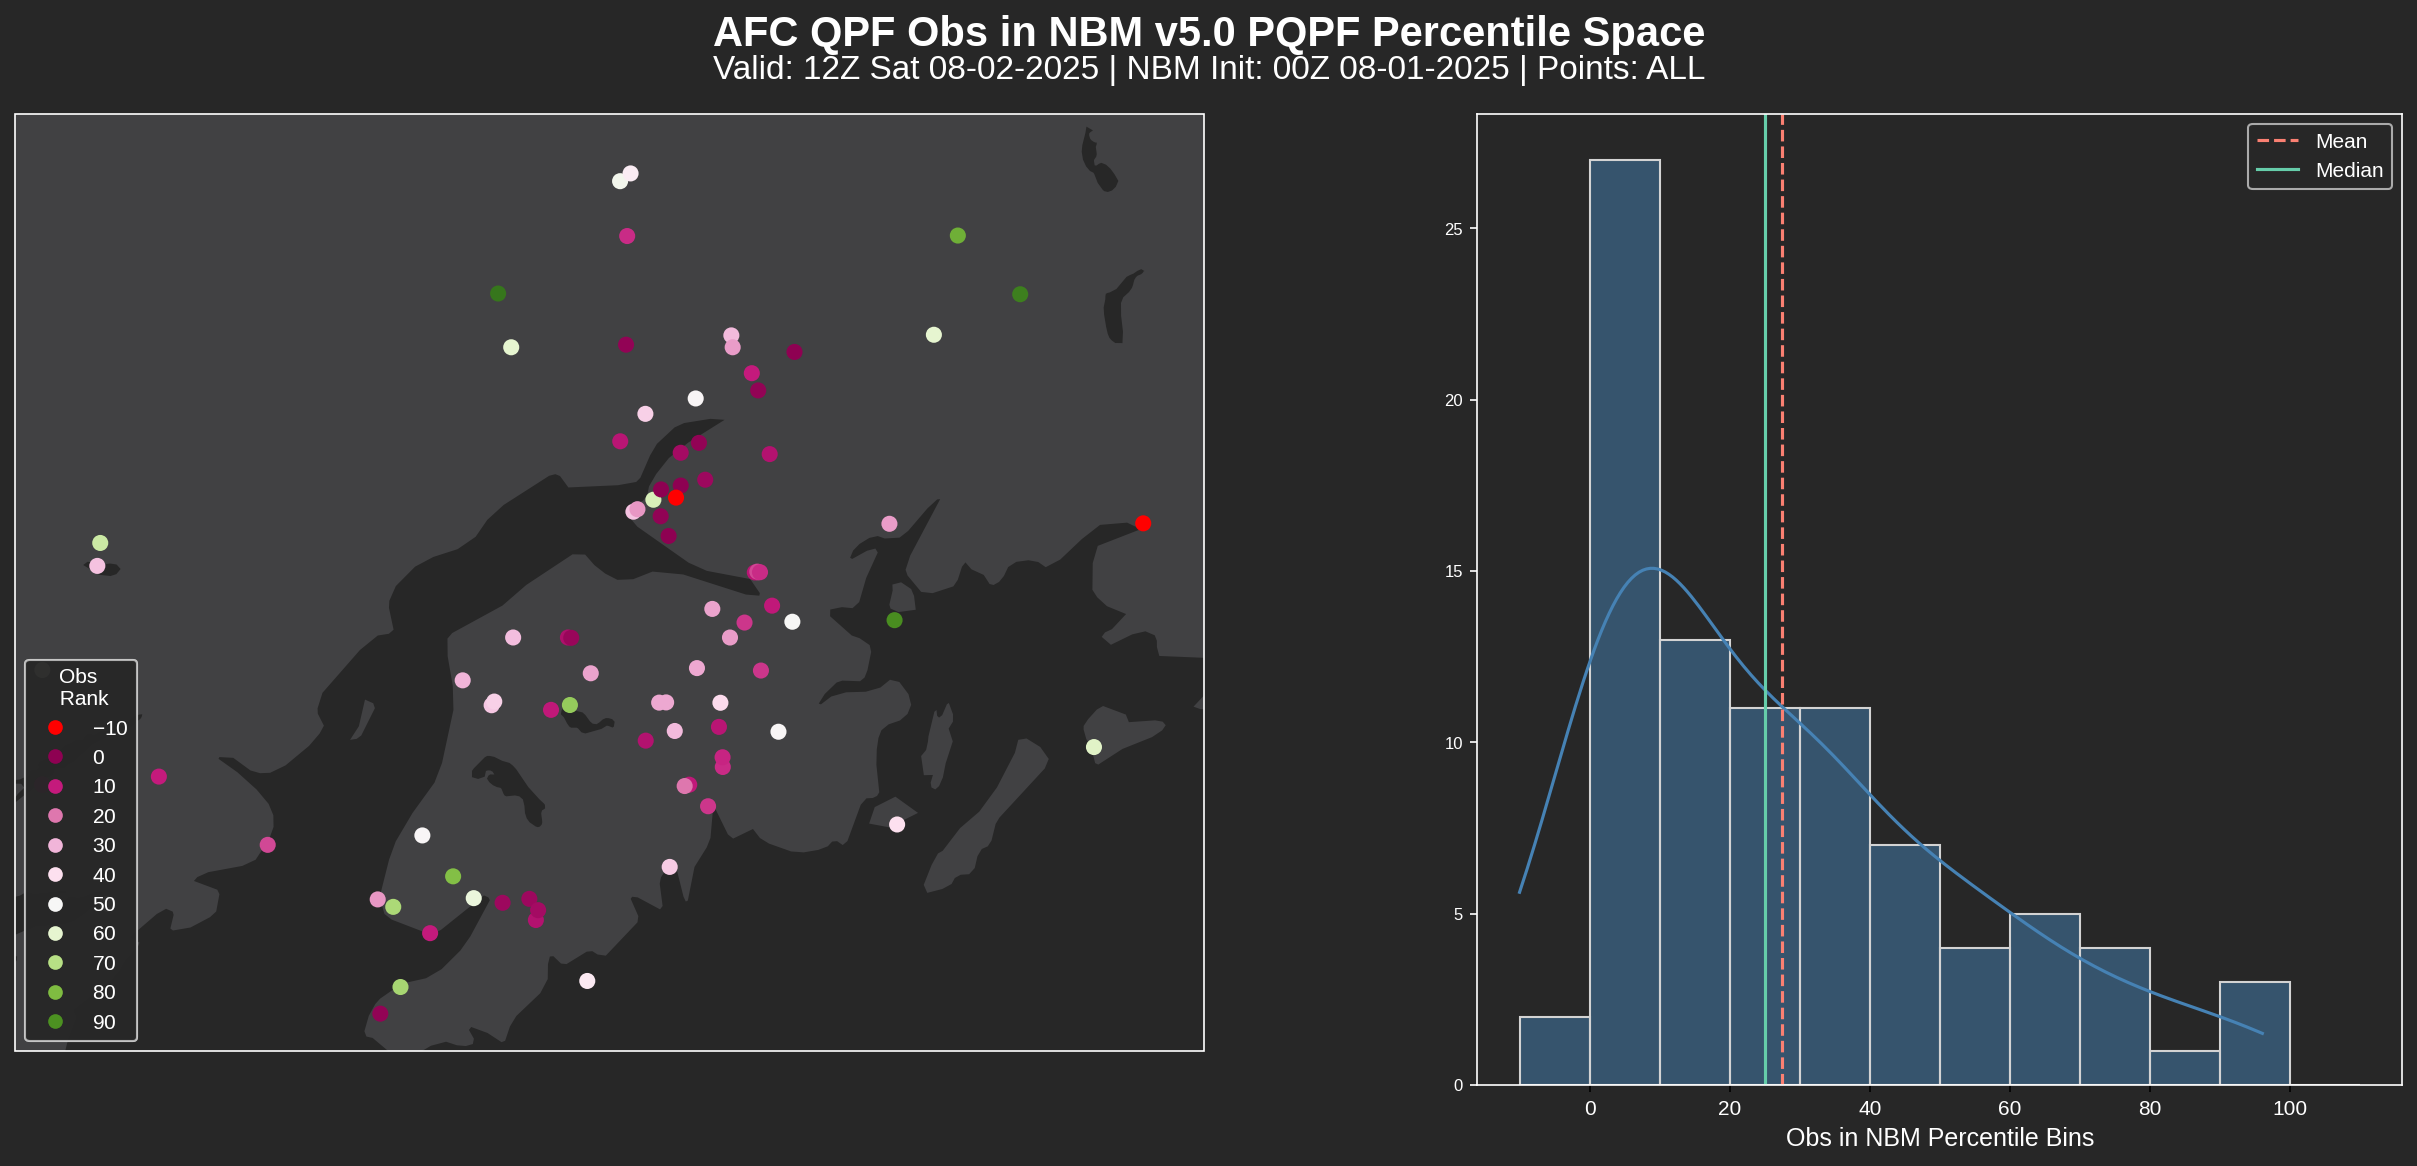

In [30]:
#@title Generate Plot
########################################################################################################################
# Finally, this section makes our plot.                                                                                #
########################################################################################################################
print("Making plot (almost done!)...")
if compare_to =="obs":
  compare_var = "ob_perc"
  compare_element = "Obs"
elif compare_to == "deterministic":
  compare_var = "NBMd_perc"
  if element =="qpf":
    compare_element = "pMean"
  else:
    compare_element = "Detr"

title_dict = {"maxt":["Max T","PMaxT"],"mint":["Min T","PMinT"], "qpf":["QPF","PQPF"], "maxwind":["Max Wind","Prob Max Wind"], "snow":["Snow Acc", "Prob Snow Acc"]}
matplotlib.rc('axes',facecolor=background_color, edgecolor=text_color)
if (element == "qpf" or element == "snow"):
  valid_datetime = valid_date
  fig_valid_date = nbm_qmd_valid_end_datetime.strftime('%Y%m%d_%HZ')
  valid_title = nbm_qmd_valid_end_datetime.strftime('%HZ %a %m-%d-%Y')
else:
  valid_datetime = datetime.strptime(valid_date,'%Y-%m-%d')
  fig_valid_date = valid_datetime.strftime('%Y%m%d')
  valid_title = valid_datetime.strftime('%a %m-%d-%Y')
if (element == "snow"):
  nbm_init_title = core_init.strftime('%HZ %m-%d-%Y')
else:
  nbm_init_title = nbm_init.strftime('%HZ %m-%d-%Y')

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

if region_selection == "CONUS":
  dataframeid = "CONUS"
  #set up multipanel plot
  west =-125.650
  south = 23.377
  east = -66.008
  north = 50.924
  width_ratios = [7,3,3,3]
  lloc = "lower right"
  fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor=background_color, frameon=True, dpi=150)
  grid = fig.add_gridspec(4,4, width_ratios=width_ratios, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
  fig.text(0.30, 0.885,f'{region_selection} {title_dict[element][0]} {compare_element} in NBM {nbm_version} Percentile Space',horizontalalignment='center',weight='bold',fontsize=25,color=text_color)
  fig.text(0.30, 0.855,f'Valid: {valid_title}  |  NBM Init: {nbm_init_title}  |  Points: {points_str}',horizontalalignment='center',fontsize=16,color=text_color)

  ax1 = fig.add_subplot(grid[:,:-2], projection=ccrs.Mercator(globe=None))
  ax2 = fig.add_subplot(grid[0,2])
  ax3 = fig.add_subplot(grid[0,3])
  ax4 = fig.add_subplot(grid[1,2])
  ax5 = fig.add_subplot(grid[1,3])
  ax6 = fig.add_subplot(grid[2:,2:])

  conus_df = pd.concat([obs["WR"], obs["CR"], obs["ER"],obs["SR"]])
  lats = conus_df["lat"].values
  lons = conus_df["lon"].values
  point_data = conus_df[compare_var].values
  mean = conus_df[compare_var].mean()
  median = conus_df[compare_var].median()
  mode = conus_df[compare_var].mode().values[0]

  proj = ccrs.PlateCarree()

  ax1.set_anchor('S')
  ax1.set_extent([west, east, south, north], crs=proj)
  #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
  ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
  #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
  ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=1)
  #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
  ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=2))
  #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
  scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, vmin=0.0, vmax=100.0)
  #handles, labels = scatter.legend_elements(num=10)
  #legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
  numcols=abs(np.amax(point_data) - np.amin(point_data))//10
  legend1 = ax1.legend(*scatter.legend_elements(num=numcols), loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
  plt.setp(legend1.get_title(), multialignment='center', color=text_color)
  for text in legend1.get_texts():
    text.set_color(text_color)
  ax1.add_artist(legend1)
  ax1.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '110m',
    edgecolor='gray', facecolor='none'))
  if cwa_outline:
    try:
      if os.path.exists("shp/w_22mr22.shp"):
        pass
      else:
        cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
        os.mkdir("shp")
        urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
        #!unzip shp/nws_cwa_outlines.zip -d shp
        with zipfile.ZipFile("shp/nws_cwa_outlines.zip", 'r') as zip_ref:
          zip_ref.extractall("shp")
      cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
      ax1.add_feature(cwa_feature)
    except:
      print("   > Aw shucks, no CWA boundaries for you. Sorry bout that.")
  if county_outline:
    try:
      if os.path.exists("shp/c_08mr23.zip"):
        pass
      else:
        county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip"
        os.mkdir("shp")
        urlretrieve(county_url, "shp/counties.zip")
        with zipfile.ZipFile("shp/counties.zip",'r') as zip_ref:
          zip_ref.extractall("shp")
      cty_feature = ShapelyFeature(Reader("shp/c_08mr23.shp").geometries().ccrs.PlateCarree(), edgecolor='white',facecolor='none',linewidth=1.0,linestyle="--",zorder=3)
      ax1.add_feature(cty_feature)
    except:
      print("   > Cannot plot county boundaries.")

  mean_wr = obs["WR"][compare_var].mean()
  median_wr = obs["WR"][compare_var].median()
  #mode_wr = obs["WR"][compare_var].mode().values[0]
  ax2.set_anchor('N')
  sns.histplot(data=obs["WR"], x=compare_var, ax=ax2, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax2.set_xlabel("Western Region", color=text_color, fontsize=12)
  ax2.axvline(mean_wr, color='salmon', linestyle='--', label="Mean")
  ax2.axvline(median_wr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax2.axvline(mode_wr, color='lightskyblue', linestyle='-', label="Mode")
  ax2.grid(False)
  for tick in ax2.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax2.get_yticklabels():
    tick.set_color(text_color)
  ax2.tick_params(axis='y',labelsize=8, color=text_color)
  legend2 = ax2.legend()
  for text in legend2.get_texts():
    text.set_color(text_color)
  ax2.set(ylabel=None)

  mean_cr = obs["CR"][compare_var].mean()
  median_cr = obs["CR"][compare_var].median()
  #mode_cr = obs["CR"][compare_var].mode().values[0]
  ax3.set_anchor('N')
  sns.histplot(data=obs["CR"], x=compare_var, ax=ax3, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax3.set_xlabel("Central Region", color=text_color, fontsize=12)
  ax3.axvline(mean_cr, color='salmon', linestyle='--', label="Mean")
  ax3.axvline(median_cr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax3.axvline(mode_cr, color='lightskyblue', linestyle='-', label="Mode")
  ax3.grid(False)
  for tick in ax3.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax3.get_yticklabels():
    tick.set_color(text_color)
  ax3.tick_params(axis='y',labelsize=8, color=text_color)
  legend3 = ax3.legend()
  for text in legend3.get_texts():
    text.set_color(text_color)
  ax3.set(ylabel=None)


  mean_er = obs["ER"][compare_var].mean()
  median_er = obs["ER"][compare_var].median()
  #mode_er = obs["ER"][compare_var].mode().values[0]
  ax4.set_anchor('N')
  sns.histplot(data=obs["ER"], x=compare_var, ax=ax4, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax4.set_xlabel("Eastern Region", color=text_color, fontsize=12)
  ax4.axvline(mean_er, color='salmon', linestyle='--', label="Mean")
  ax4.axvline(median_er, color='mediumaquamarine', linestyle='-', label="Median")
  #ax4.axvline(mode_er, color='lightskyblue', linestyle='-', label="Mode")
  ax4.grid(False)
  for tick in ax4.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax4.get_yticklabels():
    tick.set_color(text_color)
  ax4.tick_params(axis='y',labelsize=8, color=text_color)
  legend4 = ax4.legend()
  for text in legend4.get_texts():
    text.set_color(text_color)
  ax4.set(ylabel=None)


  mean_sr = obs["SR"][compare_var].mean()
  median_sr = obs["SR"][compare_var].median()
  #mode_sr = obs["SR"][compare_var].mode().values[0]
  ax5.set_anchor('N')
  sns.histplot(data=obs["SR"], x=compare_var, ax=ax5, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax5.set_xlabel("Southern Region", color=text_color, fontsize=12)
  ax5.axvline(mean_sr, color='salmon', linestyle='--', label="Mean")
  ax5.axvline(median_sr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax5.axvline(mode_sr, color='lightskyblue', linestyle='-', label="Mode")
  ax5.grid(False)
  for tick in ax5.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax5.get_yticklabels():
    tick.set_color(text_color)
  ax5.tick_params(axis='y',labelsize=8, color=text_color)
  legend5 = ax5.legend()
  for text in legend5.get_texts():
    text.set_color(text_color)
  ax5.set(ylabel=None)

  ax6.set_anchor('NC')
  sns.histplot(data=point_data, ax=ax6, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax6.set_xlabel(f'{compare_element} in NBM {title_dict[element][1]} Percentile Bins', color=text_color, fontsize=12)
  ax6.axvline(mean, color='salmon', linestyle='--', label="Mean")
  ax6.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")
  #ax6.axvline(mode, color='lightskyblue', linestyle='-', label="Mode")
  ax6.grid(False)
  for tick in ax6.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax6.get_yticklabels():
    tick.set_color(text_color)
  ax6.tick_params(axis='y',labelsize=8, color=text_color)
  legend6 = ax6.legend()
  for text in legend6.get_texts():
    text.set_color(text_color)
  ax6.set(ylabel=None)

  #figname=region_selection+"_"+element+"_"+valid_date+".png"
  #plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches=None, pad_inches=0.2, dpi='figure')

else:
  if not custom_area:
    #set up two panel plot
    if (region_selection == "AR"):
        west = -179.00
        south = 52.00
        east = -129.00
        north = 72.00
        width, height = (16,7)
        width_ratios = [9,7]
        lloc = "lower left"
    if (region_selection == "WR"):
        west = -126.917
        south = 30.586
        east = -102.740
        north = 49.755
        width, height = (16,9)
        width_ratios = [9,8]
        lloc = "lower right"
    if (region_selection == "CR"):
        west = -111.534
        south = 33.295
        east = -81.723
        north = 49.755
        width, height = (16,7)
        width_ratios = [9,7]
        lloc = "lower center"
    if (region_selection == "ER"):
        west = -86.129
        south = 31.223
        east = -66.465
        north = 47.676
        width, height = (16,7.25)
        width_ratios = [6.9,9.5]
        lloc = "lower right"
    if (region_selection == "SR"):
        west = -109.758
        south = 23.313
        east = -79.247
        north = 36.899
        width, height = (16,5.6)
        width_ratios = [10,6]
        lloc = "lower center"
    if (region_selection == "CWA"):
        west = np.min(obs[region]["lon"]) - 0.5
        south = np.min(obs[region]["lat"]) - 0.5
        east = np.max(obs[region]["lon"]) + 1.0
        north = np.max(obs[region]["lat"]) + 0.5
        width, height = (16,9)
        ratioxy = 16./9.
        width_ratios = [ratioxy, 1]
        lloc = "center right"
  else:
    west = float(custom_southwest.split(",")[1])
    south = float(custom_southwest.split(",")[0])
    east = float(custom_northeast.split(",")[1])
    north = float(custom_northeast.split(",")[0])
    width, height = (16,7)
    width_ratios = [9,7]
    lloc = "lower left"
  #width, height = (16,9)
  fig = plt.figure(constrained_layout=True, figsize=(width,height), facecolor=background_color, frameon=True, dpi=150)
  if (region_selection == "CWA"):
    dataframeid = cwa_id
  else:
    dataframeid = region_selection
  #ratioxy = 16./9.
  #width_ratios = [ratioxy, 1]
  grid = fig.add_gridspec(1,2, hspace=0.2, width_ratios=width_ratios, height_ratios = [1], wspace=0.2)
  ax1 = fig.add_subplot(grid[0,0], projection=ccrs.Mercator())
  #ax1 = fig.add_subplot(grid[0,0], projection=ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25,25)))
  ax2 = fig.add_subplot(grid[0,1], )
  fig.text(0.5, 1.05,f'{dataframeid} {title_dict[element][0]} {compare_element} in NBM v{nbm_version} {title_dict[element][1]} Percentile Space',\
           horizontalalignment='center', verticalalignment='bottom', weight='bold',fontsize=20,color=text_color)
  fig.text(0.5, 1.05,f'Valid: {valid_title} | NBM Init: {nbm_init_title} | Points: {points_str}', \
           horizontalalignment='center',verticalalignment='top', fontsize=16,color=text_color)

  lats = obs[dataframeid]["lat"].values
  lons = obs[dataframeid]["lon"].values
  point_data = obs[dataframeid][compare_var].values
  mean = obs[dataframeid][compare_var].mean()
  median = obs[dataframeid][compare_var].median()
  #mode = obs[dataframeid][compare_var].mode().values[0]
  proj = ccrs.PlateCarree()
  numcols=(abs(np.amax(point_data) - np.amin(point_data))//10) + 1

  ax1.set_anchor('N')
  ax1.set_facecolor(background_color)
  ax1.set_extent([west, east, south, north], crs=proj)
  #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
  ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
  #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
  ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2)
  #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
  ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=5))
  #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border, facecolor='none', linewidth=1, zorder=5))
  #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
  scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, zorder=2, vmin=0.0, vmax=100.0)

  if region_selection in ("CR","SR"):
    handles, labels = scatter.legend_elements(num=numcols)
    legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
  else:
    legend1 = ax1.legend(*scatter.legend_elements(num=numcols),
                      loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
  plt.setp(legend1.get_title(), multialignment='center', color=text_color)
  for text in legend1.get_texts():
    text.set_color(text_color)
  ax1.add_artist(legend1)
  #ax1.set(aspect='equal', adjustable='box')
  if cwa_outline:
    try:
      if os.path.exists("shp/w_22mr22.shp"):
        pass
      else:
        cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
        os.mkdir("shp")
        urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
        #!unzip shp/nws_cwa_outlines.zip -d shp
      with zipfile.ZipFile("shp/nws_cwa_outlines.zip", 'r') as zip_ref:
        zip_ref.extractall("shp")
        cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1, linestyle='-', zorder=4)
        ax1.add_feature(cwa_feature)
    except:
      print("Aw shucks, no CWA boundaries for you. Sorry bout that.")
  if county_outline:
    try:
      if os.path.exists("shp/c_08mr23.shp"):
        pass
      else:
        county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip"
        if os.path.exists("shp/counties.zip"):
          pass
        else:
          if os.path.exists("shp"):
            pass
          else:
            os.mkdir("shp")
          urlretrieve(county_url, "shp/counties.zip")
          print("   >> Downloaded county zip file")

      with zipfile.ZipFile("shp/counties.zip",'r') as cty_ref:
        cty_ref.extractall("shp")
        print("   >> Extracted county shape files")
        cty_feature = ShapelyFeature(Reader("shp/c_08mr23.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
        ax1.add_feature(cty_feature)
    except:
      print("   >> Cannot plot county boundaries.")

  #if region_selection == "SR":
  #ax2.set(aspect=1)
  ax2.set_anchor('C')
  sns.histplot(data=obs[dataframeid], x=compare_var, ax=ax2, kde=True, bins=range(-10,115,10),color='steelblue',edgecolor='lightgrey')
  ax2.set_xlabel(f'{compare_element} in NBM Percentile Bins', color=text_color, fontsize=12)
  ax2.axvline(mean, color='salmon', linestyle='--', label="Mean")
  ax2.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")

  ax2.grid(False)
  for tick in ax2.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax2.get_yticklabels():
    tick.set_color(text_color)
  ax2.tick_params(axis='y',labelsize=8, color=text_color)
  legend2 = ax2.legend()
  for text in legend2.get_texts():
    text.set_color(text_color)
  ax2.set(ylabel=None)


figname="map_"+nbm_version+"_"+dataframeid+"_"+compare_element+"_"+element+"_"+nbm_init.strftime('%Y%m%d')+"_"+valid_end_datetime.strftime('%Y%m%d')+".png"
plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0.2, dpi='figure')
print(f'   > Done! Saved plot as {figname}')